In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
from koopman.simulation.simulator import rk4_step, simulate
from koopman.simulation.systems import DuffingOscillator
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FormatStrFormatter
import casadi as ca
from scipy.linalg import expm
from spatialmath.base import *

import jax
import jax.numpy as jnp
from jax import jacfwd, vmap

duffing = DuffingOscillator(DuffingOscillator.Params(delta=0.5))

In [3]:
Jx = jax.jacfwd(duffing.dynamics, argnums=0)
Ju = jax.jacfwd(duffing.dynamics, argnums=1)

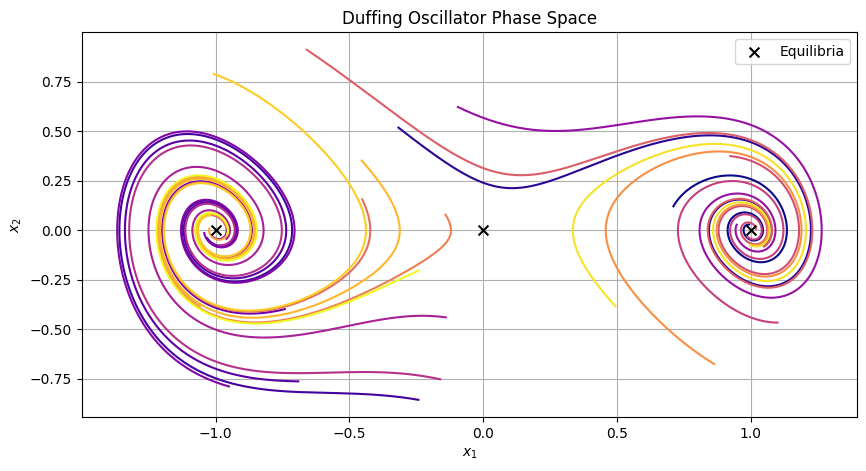

In [4]:
x0 = np.column_stack([
    np.random.uniform(-1.1, 1.1, size=(20,)),
    np.random.uniform(-1.1, 1.1, size=(20,))
])
N_traj = x0.shape[0]
tf=10.0
dt=0.01

u_fn = lambda t, x: np.zeros((N_traj, duffing.nu))

ts, x_hist, u_hist = simulate(duffing.dynamics, tf, dt, u_fn, x0)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
colors = plt.get_cmap('plasma', N_traj)

for i in range(N_traj):
    ax.plot(x_hist[:, i, 0], x_hist[:, i, 1], color=colors(i), zorder=2)

ax.scatter([-1, 0, 1], [0, 0, 0], s=50, color='black', marker='x', zorder=3, label='Equilibria')
ax.legend()

ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.set_title("Duffing Oscillator Phase Space")
ax.grid(True, zorder=1)
plt.show()

In [192]:
from sklearn.cluster import KMeans

def compute_centers_from_data(X: np.ndarray, N_centers: int):
    # X shape: (num_samples, state_dim)
    kmeans = KMeans(n_clusters=N_centers, n_init=10)
    kmeans.fit(X)
    return jnp.array(kmeans.cluster_centers_)

def make_sigmas(centers):
    return jnp.where(jnp.linalg.norm(centers, axis=1) < 0.5, 0.3, 1.2)

def build_liftings(centers, xmin, xmax):
    assert len(xmin) == len(xmax) == duffing.nx, "xmin and xmax must have the same length as the state dimension"
    eps = 1e-6
    sigma = 0.3
    # sigmas = make_sigmas(centers)
    
    def phi(x):
        dists = jnp.linalg.norm(x - centers, axis=-1)
        rbfs = jnp.exp(-0.5 * (dists / sigma) ** 2)
        # rbfs = dists**2 * jnp.log(dists + eps)
        # rbfs = jnp.sqrt((dists / sigma)**2 + 1)
        x1, x2 = x
        polys = jnp.array([
            x1**2, x2**2, x1*x2,
            x1**3, x2**3
        ])

        return jnp.concat([
            x,
            # rbfs,
            polys
        ])
        
    phi_jac = jacfwd(phi)
    
    def phi_dot(x, xdot):        
        J = phi_jac(x)         # shape (nz, nx)
        return J @ xdot        # shape (nz,)

    batch_phi = vmap(phi)
    batch_phi_dot = vmap(phi_dot)
    
    _phi = lambda x : phi(x) if x.ndim == 1 else batch_phi(x)
    _phi_dot = lambda x, xdot : phi_dot(x, xdot) if x.ndim == 1 else batch_phi_dot(x, xdot)
    
    return _phi, _phi_dot

def koopman_Y(phi, u):
    u_z_kron = jnp.kron(u, phi)
    return jnp.concat([phi, u, u_z_kron], axis=-1)
    
batch_koopman_Y = vmap(koopman_Y)

In [193]:
# Generate some new data for training
N_traj = 10_000

# us = np.zeros((N_traj, 1))
us = np.random.uniform(-10.0, 10.0, size=(N_traj, duffing.nu))
xs = np.column_stack([
    np.random.uniform(-2, 2, size=(N_traj,)),
    np.random.uniform(-2, 2, size=(N_traj,))
])

xs_dot = duffing.dynamics(xs, us)

# Get the lifted states
xmin = np.min(xs, axis=0)
xmax = np.max(xs, axis=0)
# centers = compute_centers_from_data(xs, N_centers=30)
centers = np.random.uniform(np.array([-0.2, -0.2]), np.array([0.2, 0.2]), size=(10, duffing.nx))
phi, phi_dot = build_liftings(centers, xmin, xmax)

print(f"{xs.shape=}, {xs_dot.shape=}")

xs.shape=(10000, 2), xs_dot.shape=(10000, 2)


In [194]:
# Fit the lifting
phi_xs = phi(xs)
phi_xs_dot = phi_dot(xs, xs_dot)
Y = batch_koopman_Y(phi_xs, us)

nz = phi_xs.shape[-1]
nu = us.shape[-1]

Wkoop = ( jnp.linalg.pinv(Y, rtol=1e-12) @ phi_xs_dot ).T
Akoop = Wkoop[:, :nz]
Bkoop = Wkoop[:, nz:nz+nu]
Ckoop = Wkoop[:, nz+nu:]

print(f"A shape: {Akoop.shape}")
print(f"B shape: {Bkoop.shape}")
print(f"C shape: {Ckoop.shape}")

print(f"rank(A): {np.linalg.matrix_rank(Akoop)}")
print(f"cond(A): {np.linalg.cond(Akoop)}")

A shape: (7, 7)
B shape: (7, 1)
C shape: (7, 7)
rank(A): 7
cond(A): 776.6942749023438


In [202]:
plot_x0 = np.column_stack([
    np.random.uniform(-2, 2, size=(20,)),
    np.random.uniform(-2, 2, size=(20,))
])
u_fn = lambda t, x: jnp.zeros((20, duffing.nu))
_, plot_xs, plot_us = simulate(duffing.dynamics, tf, dt, u_fn, plot_x0)

print(f"{plot_xs.shape=}, {plot_us.shape=}")

plot_xs.shape=(1001, 20, 2), plot_us.shape=(1000, 20, 1)


/tmp/ipykernel_3256865/3163693622.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=2.0)


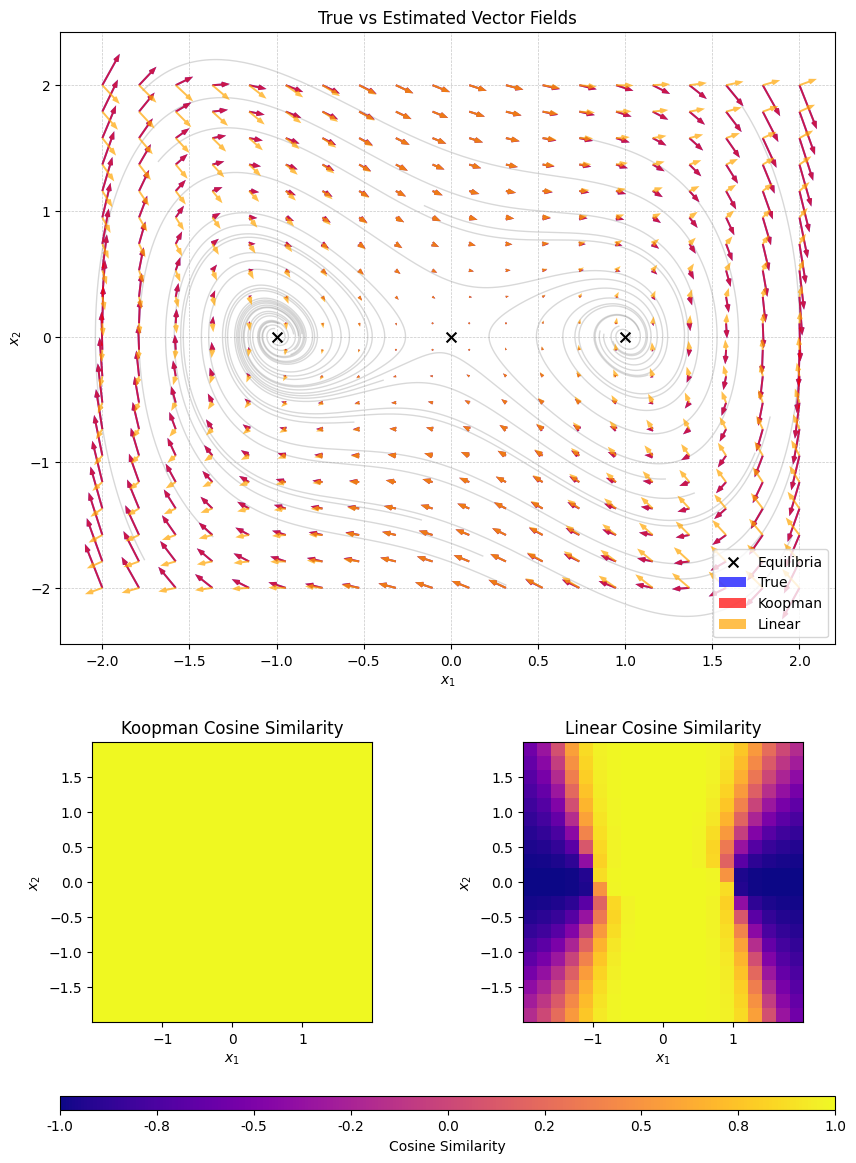

In [203]:
def normalize(vectors):
    norms = np.linalg.norm(vectors, axis=1, keepdims=True)
    return vectors / np.clip(norms, 1e-8, np.inf)

# Grid resolution
num_points = 20

# Create grid of (theta, omega)
x1_vals = np.linspace(xmin[0], xmax[0], num_points)
x2_vals = np.linspace(xmin[1], xmax[1], num_points)
X1, X2 = np.meshgrid(x1_vals, x2_vals)  # shape (num_points, num_points)

# Flatten grid for vectorized computation
grid_points = np.stack([X1.ravel(), X2.ravel()], axis=-1)  # shape (N^2, 2)
us_null = np.zeros((grid_points.shape[0], duffing.nu))

grid_points_dot = duffing.dynamics(grid_points, us_null)

# Estimated dynamics using koopman model
phi_grid_points = phi(grid_points)
phi_grid_points_dot = phi_grid_points @ Akoop.T
grid_points_dot_koop = phi_grid_points_dot[:, :duffing.nx]

# Estimated dynamics using linearized model
x0 = jnp.array([0.0, 0.0])
u0 = jnp.array([0.0])

A = Jx(x0, u0)
B = Ju(x0, u0)
f0 = duffing.dynamics(x0, u0)
grid_points_dot_lin = (grid_points - x0) @ A.T + f0

# Normalize the vectors
true_norm = normalize(grid_points_dot)
koop_norm = normalize(grid_points_dot_koop)
lin_norm = normalize(grid_points_dot_lin)

cos_sim_koop = np.sum(true_norm * koop_norm, axis=1).reshape(num_points, num_points)
cos_sim_lin = np.sum(true_norm * lin_norm, axis=1).reshape(num_points, num_points)

fig = plt.figure(figsize=(10, 14))

# Layout: 2 rows
outer_gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1.5], hspace=0.2)

# Top: main vector field plot
ax_field = fig.add_subplot(outer_gs[0])
ax_field.scatter([-1, 0, 1], [0, 0, 0], s=50, color='black', marker='x', zorder=3, label='Equilibria')
for i in range(plot_xs.shape[1]):
    ax_field.plot(plot_xs[:, i, 0], plot_xs[:, i, 1], color='gray', linewidth=1, alpha=0.3, zorder=2)
ax_field.quiver(grid_points[:, 0], grid_points[:, 1], grid_points_dot[:, 0], grid_points_dot[:, 1],
                color='blue', alpha=0.7, label='True', angles='xy', scale_units='xy', scale=20,
                width=0.0025, headwidth=3, headlength=4, zorder=3)
ax_field.quiver(grid_points[:, 0], grid_points[:, 1], grid_points_dot_koop[:, 0], grid_points_dot_koop[:, 1],
                color='red', alpha=0.7, label='Koopman', angles='xy', scale_units='xy', scale=20,
                width=0.0025, headwidth=3, headlength=4, zorder=3)
ax_field.quiver(grid_points[:, 0], grid_points[:, 1], grid_points_dot_lin[:, 0], grid_points_dot_lin[:, 1],
                color='orange', alpha=0.7, label='Linear', angles='xy', scale_units='xy', scale=20,
                width=0.0025, headwidth=3, headlength=4, zorder=3)
ax_field.set_title("True vs Estimated Vector Fields")
ax_field.set_xlabel(r"$x_1$")
ax_field.set_ylabel(r"$x_2$")
ax_field.legend(loc='lower right')
ax_field.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Bottom: two heatmaps side-by-side and a shared horizontal colorbar
bottom_gs = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=outer_gs[1], height_ratios=[20, 1],
                                             hspace=0.5, wspace=0.25)

ax_koop = fig.add_subplot(bottom_gs[0, 0])
im1 = ax_koop.imshow(cos_sim_koop, origin='lower', extent=[xmin[0], xmax[0], xmin[1], xmax[1]],
                     cmap='plasma', vmin=-1, vmax=1)
ax_koop.set_title("Koopman Cosine Similarity")
ax_koop.set_xlabel(r"$x_1$")
ax_koop.set_ylabel(r"$x_2$")

ax_lin = fig.add_subplot(bottom_gs[0, 1])
im2 = ax_lin.imshow(cos_sim_lin, origin='lower', extent=[xmin[0], xmax[0], xmin[1], xmax[1]],
                    cmap='plasma', vmin=-1, vmax=1)
ax_lin.set_title("Linear Cosine Similarity")
ax_lin.set_xlabel(r"$x_1$")
ax_lin.set_ylabel(r"$x_2$")

# Horizontal colorbar spanning both
cax = fig.add_subplot(bottom_gs[1, :])
cbar = fig.colorbar(im1, cax=cax, orientation='horizontal', format="%.1f")
cbar.set_label("Cosine Similarity")

plt.tight_layout(pad=2.0)
plt.show()

eval_true_xs.shape=(11, 2)
eval_koop_xs.shape=(11, 2)


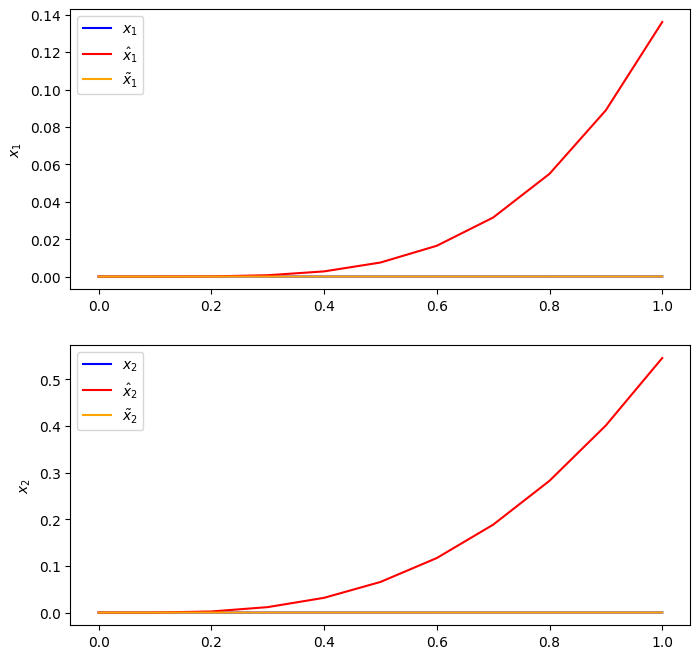

In [183]:
# eval_x0 = jnp.array( np.random.uniform(-1.1, 1.1, size=(2,)) )
eval_x0 = np.array([0.0001, 0.0])
eval_z0 = phi(eval_x0)

u_fn = lambda t, x: np.zeros((duffing.nu))

eval_tf = 1.0
eval_dt = 0.1

eval_ts, eval_true_xs, _ = simulate(duffing.dynamics, eval_tf, eval_dt, u_fn, eval_x0)

linear_dynamics = lambda x, u : f0 + A @ (x - x0) + B @ (u - u0)
_, eval_linear_xs, _ = simulate(linear_dynamics, eval_tf, eval_dt, u_fn, eval_x0)

koopman_dynamics = lambda x, u : Wkoop @ koopman_Y(x, u)
_, eval_koop_zs, _ = simulate(koopman_dynamics, eval_tf, eval_dt, u_fn, eval_z0)
eval_koop_xs = eval_koop_zs[:, :duffing.nx]

print(f"{eval_true_xs.shape=}")
print(f"{eval_koop_xs.shape=}")

fig, ax = plt.subplots(2, 1, figsize=(8, 8))
ax[0].plot(eval_ts, eval_true_xs[:, 0], label=r"$x_1$", color='blue')
ax[0].plot(eval_ts, eval_koop_xs[:, 0], label=r"$\hat{x}_1$", color='red')
ax[0].plot(eval_ts, eval_linear_xs[:, 0], label=r"$\tilde{x}_1$", color='orange')

ax[0].set_ylabel(r"$x_1$")
ax[0].legend()

ax[1].plot(eval_ts, eval_true_xs[:, 1], label=r"$x_2$", color='blue')
ax[1].plot(eval_ts, eval_koop_xs[:, 1], label=r"$\hat{x}_2$", color='red')
ax[1].plot(eval_ts, eval_linear_xs[:, 1], label=r"$\tilde{x}_2$", color='orange')

ax[1].set_ylabel(r"$x_2$")
ax[1].legend()

plt.show()

In [187]:
def build_mpc_problem(dt, N, u_max):
    Wkoop_ca = ca.DM(np.array(Wkoop))

    # Duffing dynamics
    def duffing_koopman_dynamics(phi, u):
        u_phi_kron = ca.kron(u, phi)
        Y = ca.vertcat(phi, u, u_phi_kron)
        
        return Wkoop_ca @ Y

    # Hermite-Simpson defect constraint
    def hermite_simpson_constraint(xk, xkp1, uk, dt):
        fk = duffing_koopman_dynamics(xk, uk)
        fkp1 = duffing_koopman_dynamics(xkp1, uk)
        xm = 0.5 * (xk + xkp1) + (dt / 8) * (fk - fkp1)
        fm = duffing_koopman_dynamics(xm, uk)
        return xk + (dt / 6) * (fk + 4 * fm + fkp1) - xkp1

    # Problem setup
    nz = Wkoop_ca.shape[0]
    nu = duffing.nu
    
    Q = np.diag(1e-3 * np.ones(nz))
    Q[0, 0] = 10.0
    Q[1, 1] = 1.0
    
    R = np.diag([0.1])

    # Optimization setup
    opti = ca.Opti()
    Z = opti.variable(nz, N+1)
    U = opti.variable(nu, N)
    z0 = opti.parameter(nz)
    z_goal = opti.parameter(nz)

    # Collocation constraints
    for k in range(N):
        defect = hermite_simpson_constraint(Z[:, k], Z[:, k+1], U[:, k], dt)
        opti.subject_to(defect == 0)

    # Initial state constraint
    opti.subject_to(Z[:, 0] == z0)

    # Control bounds
    opti.subject_to(opti.bounded(-u_max, U, u_max))

    # Cost function
    cost = 0
    for k in range(N):
        zerr = Z[:, k] - z_goal
        cost += ca.mtimes([zerr.T, Q, zerr])
        cost += ca.mtimes([U[:, k].T, R, U[:, k]])
    
    opti.minimize(cost)

    # Solver setup
    opti.solver("ipopt", {
        "print_time": False,
        "ipopt": {
            "print_level": 0,
            "sb": "yes"  # Suppress banner
        }
    })

    def solve_mpc(x0_val, xf_val, U_init=None):
        z0_val = np.asarray( phi(x0_val) )
        zf_val = np.asarray( phi(xf_val) )
        
        # Set parameters
        opti.set_value(z0, z0_val)
        opti.set_value(z_goal, zf_val)
        
        ts = np.linspace(0, 1, N+1)
        Z_init = (1 - ts) * z0_val[:, None] + ts * zf_val[:, None]  # linear interpolation
        
        if U_init is None:
            U_init = np.random.randn(nu, N)  # initialize control to noise

        opti.set_initial(Z, Z_init)
        opti.set_initial(U, U_init)

        # Solve
        sol = opti.solve()
        Z_sol = sol.value(Z)
        U_sol = sol.value(U)
        
        if U_sol.ndim == 1:
            U_sol = U_sol[None, :]
        
        return Z_sol.T, U_sol.T

    return solve_mpc

solver = build_mpc_problem(dt=0.05, N=50, u_max=1)

x0_val = np.array([1.5, 1.0])
xf_val = np.array([0.0, 0.0])
z_sol, u_sol = solver(x0_val, xf_val)
x_sol = z_sol[:, :duffing.nx]

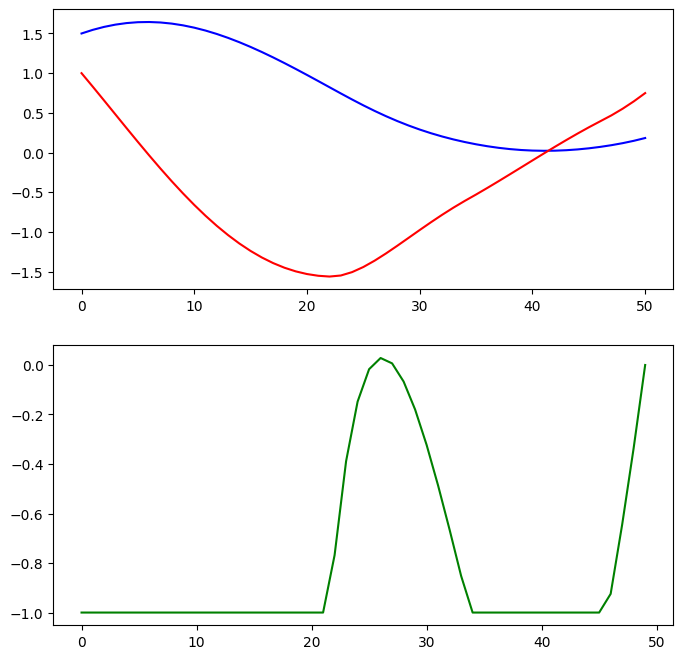

In [188]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8))
ax[0].plot(x_sol[:, 0], label=r"$x_1$", color='blue')
ax[0].plot(x_sol[:, 1], label=r"$x_2$", color='red')

ax[1].plot(u_sol[:, 0], label=r"$u$", color='green')

In [189]:
mpc_dt = 0.05
mpc_N = 20
mpc_u_max = 1.0

ctrl_tf = 5.0
ctrl_dt = 0.05

T = int( np.ceil(ctrl_tf / ctrl_dt) )

ctrl_x_hist = np.zeros((T + 1, duffing.nx))
ctrl_u_hist = np.zeros((T, duffing.nu))

x0 = np.array([1.5, 1.0])
x_goal = np.array([-1.0, 0.0])

ctrl_x_hist[0] = x0

u_init = None

for i in range(T):
    x_curr = ctrl_x_hist[i]
    _, u_sol = solver(x_curr, x_goal, u_init)
    
    # Store the control input for the next step
    u_init = np.roll(u_sol, shift=-1, axis=0)
    u_init[-1] = 0.0
    
    x_next = rk4_step(duffing.dynamics, x_curr, u_sol[0], dt=ctrl_dt)
    ctrl_x_hist[i + 1] = x_next

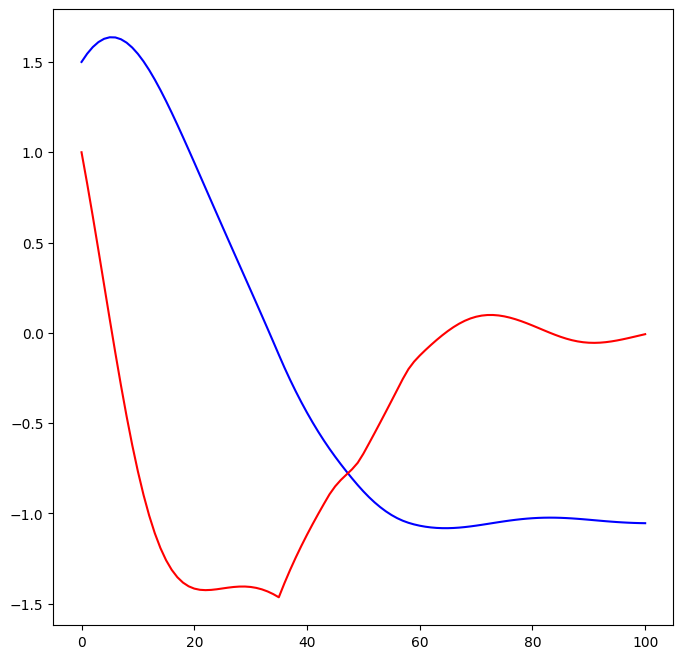

In [191]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(ctrl_x_hist[:, 0], label=r"$x_1$", color='blue')
ax.plot(ctrl_x_hist[:, 1], label=r"$x_2$", color='red')

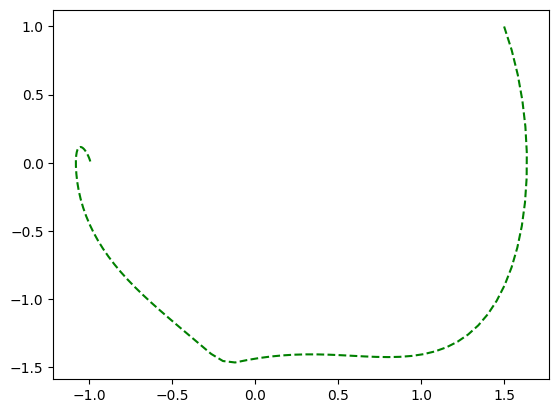

In [119]:
plt.plot(ctrl_x_hist[:, 0], ctrl_x_hist[:, 1], label='MPC Trajectory', color='green', linestyle='--')